In [1]:
# import modules
import uproot, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 18
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [2]:
def getWeight(fb, sample):
    # lumi = 25767.5
    lumi = 135000
    weight = fb['mconly_weight']/fb['mc_weight_sum']*fb['xsec_ami']*fb['filter_eff_ami']*fb['kfactor_ami']*fb['pu_weight']*fb['jvt_weight']*1000*lumi
    if sample in ['ggHyyd','WH','VBF','ZH'] : 
        xsec_sig = 0.052 #if ( period == 'Run3' or 'mc23' in period ) else 0.048
        # if sample != 'ggHyyd' : xsec_sig = fb['xsec_ami']
        br = 0.01
        weight = fb['mconly_weight']/fb['mc_weight_sum']*xsec_sig*fb['pu_weight']*fb['jvt_weight']*fb['filter_eff_ami']*fb['kfactor_ami']*1000*lumi*br
    return weight

def getSampleDict():
    sample_dict = {}
    sample_dict['Zjets'] = {
        'color': 'darkgreen',   # approximates ROOT.kGreen-2
        'legend': r'Z($\nu\nu$, ll)+jets',
        'tree': 'nominal',
        'filenames': ['Zjets']
    }
    sample_dict['Zgamma'] = {
        'color': '#e6550d',      # approximates ROOT.kOrange+7
        'legend': r'Z($\nu\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Zgamma']
    }
    sample_dict['Wgamma'] = {
        'color': 'darkorange',  # approximates ROOT.kOrange+1
        'legend': r'W($l\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Wgamma']
    }
    sample_dict['Wjets'] = {
        'color': 'teal',        # approximates ROOT.kTeal+5
        'legend': r'W($l\nu$)+jets',
        'tree': 'nominal',
        'filenames': ['Wjets']
    }
    sample_dict['gammajet_direct'] = {
        'color': 'royalblue',   # approximates ROOT.kBlue+2
        'legend': r'$\gamma$+jets direct',
        'tree': 'gammajets',
        'filenames': ['gammajet_direct']
    }
    sample_dict['gammajet_frag'] = {
        'color': 'navy',        # approximates ROOT.kBlue-5
        'legend': r'$\gamma$+jets frag',
        'tree': 'gammajets',
        'filenames': ['gammajet_frag']
    }
    sample_dict['dijet'] = {
        'color': 'cyan',        # approximates ROOT.kCyan+1
        'legend': 'multijets',
        'tree': 'dijets',
        'filenames': ['dijet']
    }
    sample_dict['ggHyyd'] = {
        'color': 'red',         # approximates ROOT.kRed
        'legend': r'ggH, H$\rightarrow\gamma\gamma_{d}$',
        'tree': 'nominal',
        'filenames': ['ggHyyd']
    }
    return sample_dict
sample_dict = getSampleDict()

def getVarDict(fb, process, var_name=None):
    var_dict = {}

    # this has the same size as weight, so don't need adjustment on weighting
    if var_name is None or var_name == 'vtx_sumPt':
        var_dict['vtx_sumPt'] = {
            'var': ak.flatten(fb['vtx_sumPt']),
            'bins': np.linspace(0, 100, 20+1),  # 21 edges for 20 bins
            'title': r'vtx\_sumPt'
        }

    if var_name is None or var_name == 'n_ph':
        var_dict['n_ph'] = {
            'var': fb['n_ph'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph}$'
        }

    if var_name is None or var_name == 'n_ph_baseline':
        var_dict['n_ph_baseline'] = {
            'var': fb['n_ph_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph\_baseline}$'
        }

    if var_name is None or var_name == 'n_el_baseline':
        var_dict['n_el_baseline'] = {
            'var': fb['n_el_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{el\_baseline}$'
        }

    if var_name is None or var_name == 'n_mu_baseline':
        var_dict['n_mu_baseline'] = {
            'var': fb['n_mu_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{mu\_baseline}$'
        }

    if var_name is None or var_name == 'n_tau_baseline':
        var_dict['n_tau_baseline'] = {
            'var': fb['n_tau_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{tau\_baseline}$'
        }

    if var_name is None or var_name == 'puWeight':
        var_dict['puWeight'] = {
            'var': fb['pu_weight'],
            'bins': np.linspace(0, 2, 50+1),
            'title': r'PU weight',
            'shift': '+0'
        }

    if var_name is None or var_name == 'actualIntPerXing':
        var_dict['actualIntPerXing'] = {
            'var': fb['actualIntPerXing'],
            'bins': np.linspace(0, 100, 50+1),
            'title': r'$\langle\mu\rangle$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'mt':
        var_dict['mt'] = {
            'var': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                           (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
            'bins': np.linspace(0, 300, 15+1),
            'title': r'$m_T\ [GeV]$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'metsig':
        var_dict['metsig'] = {
            'var': fb['met_tst_sig'],
            'bins': np.linspace(0, 30, 15+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'metsigres':
        var_dict['metsigres'] = {
            'var': fb['met_tst_et'] / fb['met_tst_sig'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'met':
        var_dict['met'] = {
            'var': fb['met_tst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$',
            'shift': '+50000'
        }

    if var_name is None or var_name == 'met_noJVT':
        var_dict['met_noJVT'] = {
            'var': fb['met_tst_noJVT_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$'
        }

    if var_name is None or var_name == 'met_cst':
        var_dict['met_cst'] = {
            'var': fb['met_cst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ CST\ [GeV]$'
        }

    if var_name is None or var_name == 'met_track':
        var_dict['met_track'] = {
            'var': fb['met_track_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ Track\ [GeV]$'
        }

    if var_name is None or var_name == 'dmet':
        var_dict['dmet'] = {
            'var': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
            'bins': np.linspace(-100000, 100000, 20+1),
            'title': r'$E_{T,\mathrm{noJVT}}^{miss}-E_T^{miss}\ [GeV]$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'ph_pt':
        var_dict['ph_pt'] = {
            'var': ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\gamma}\ [GeV]$',
            'shift': '-150000'
        }

    if var_name is None or var_name == 'ph_eta':
        var_dict['ph_eta'] = {
            'var': np.abs(ak.firsts(fb['ph_eta'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\eta^{\gamma}$'
        }

    if var_name is None or var_name == 'ph_phi':
        var_dict['ph_phi'] = {
            'var': ak.firsts(fb['ph_phi']),
            'bins': np.linspace(-4, 4, 50+1),
            'title': r'$\phi^{\gamma}$'
        }

    if var_name is None or var_name == "jet_central_eta":
        jet_central_eta_tmp = ak.firsts(fb['jet_central_eta'])
        var_dict['jet_central_eta'] = {
            'var': ak.fill_none(jet_central_eta_tmp, -999),
            'bins': np.linspace(-4, 4, 50+1), 
            'title': r'$\eta^{\mathrm{jets}}$'
        }

    # Jet central pt1 (first jet)
    if var_name is None or var_name == "jet_central_pt1":
        jet_central_pt1_tmp = ak.firsts(fb['jet_central_pt'])
        var_dict['jet_central_pt1'] = {
            'var': ak.fill_none(jet_central_pt1_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j1}\ [GeV]$'
        }

    # Jet central pt2 (second jet, if available)
    if var_name is None or var_name == "jet_central_pt2":
        jet_central_pt2_tmp = ak.mask(fb['jet_central_pt'], ak.num(fb['jet_central_pt']) >= 2)[:, 1]
        var_dict['jet_central_pt2'] = {
            'var': ak.fill_none(jet_central_pt2_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j2}\ [GeV]$'
        }

    # Jet central pt (all jets)
    if var_name is None or var_name == "jet_central_pt":
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_pt'])[0])
        var_dict['jet_central_pt'] = {
            'var': ak.flatten(fb['jet_central_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j}\ [GeV]$'
    }

    if var_name is None or var_name == 'dphi_met_phterm':
        var_dict['dphi_met_phterm'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'dphi_met_ph':
        var_dict['dphi_met_ph'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$'
        }

    if var_name is None or var_name == 'dphi_met_jetterm':
        var_dict['dphi_met_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_phterm_jetterm':
        var_dict['dphi_phterm_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] > 0,
                            np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{\gamma},\, E_T^{jet})$'
        }

    # Delta phi (photon vs. central jet1)
    if var_name is None or var_name == 'dphi_ph_centraljet1':
        dphi_ph_centraljet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_ph_centraljet1'] = {
            'var': ak.fill_none(dphi_ph_centraljet1_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(\gamma,\, j1)$'
        }

    # # Delta phi (photon vs. jet1)
    if var_name is None or var_name == 'dphi_ph_jet1':
        dphi_ph_jet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_ph_jet1'] = {
            'var': ak.fill_none(dphi_ph_jet1_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(\gamma,\, j1)$'
        }

    # # Delta phi (central jet1 vs. jet2) (repeated with dphi_jj)
    # if var_name is None or var_name == 'dphi_central_jet1_jet2':
    #     phi1_tmp = ak.firsts(fb['jet_central_phi'])
    #     phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
    #     dphi_central_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    #     var_dict['dphi_central_jet1_jet2'] = {
    #         'var': ak.fill_none(dphi_central_tmp, -999),
    #         'bins': np.linspace(0, 4, 50+1),
    #         'title': r'$\Delta\phi(j1,\, j2)$'
    #     }

    # Met plus photon pt
    if var_name is None or var_name == 'metplusph':
        var_dict['metplusph'] = {
            'var': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}+p_T^{\gamma}\ [GeV]$'
        }

    # # Fail JVT jet pt (all)
    if var_name is None or var_name == 'failJVT_jet_pt':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['failJVT_jet_pt'])[0])
        var_dict['failJVT_jet_pt'] = {
            'var': ak.flatten(fb['failJVT_jet_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet}}\ [GeV]$'
        }

    # # Fail JVT jet pt1 (first element)
    if var_name is None or var_name == 'failJVT_jet_pt1':
        failJVT_jet_pt_tmp = ak.firsts(fb['failJVT_jet_pt'])
        var_dict['failJVT_jet_pt1'] = {
            'var': ak.fill_none(failJVT_jet_pt_tmp, -999),
            'bins': np.linspace(20000, 60000, 40+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet1}}\ [GeV]$'
        }

    if var_name is None or var_name == 'softerm':
        var_dict['softerm'] = {
            'var': fb['met_softerm_tst_et'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{soft}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm':
        var_dict['jetterm'] = {
            'var': fb['met_jetterm_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm_sumet':
        var_dict['jetterm_sumet'] = {
            'var': fb['met_jetterm_sumet'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'n_jet':
        var_dict['n_jet'] = {
            'var': fb['n_jet'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}$'
        }

    if var_name is None or var_name == 'n_jet_central':
        var_dict['n_jet_central'] = {
            'var': fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{central}$'
        }

    if var_name is None or var_name == 'n_jet_fwd':
        var_dict['n_jet_fwd'] = {
            'var': fb['n_jet'] - fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{fwd}$'
        }

    # if var_name is None or var_name == 'vertex':
    #     var_dict['vertex'] = {
    #         'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == 
    #                 np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z']))),
    #         'bins': np.linspace(0, 2, 2+1),
    #         'title': r'good PV'
    #     }

    if var_name is None or var_name == 'goodPV':
        var_dict['goodPV'] = {
            'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5),
            'bins': np.linspace(0, 2, 2+1),
            'title': r'good PV'
        }
    # # Delta phi (met vs. central jet)
    if var_name is None or var_name == 'dphi_met_central_jet':
        dphi_met_central_jet_tmp = np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_met_central_jet'] = {
            'var': ak.fill_none(dphi_met_central_jet_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, jet)$'
        }

    # # Counts: constant 0.5 (typically used for normalization)
    # var_dict['counts'] = {
    #     'var': 0.5,
    #     'bins': np.linspace(0, 1, 1+1),
    #     'title': ''
    # }

    # # Jet central timing1
    if var_name is None or var_name == 'jet_central_timing1':
        jet_central_timing1_tmp = ak.firsts(fb['jet_central_timing'])
        var_dict['jet_central_timing1'] = {
            'var': ak.fill_none(jet_central_timing1_tmp, -999),
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central timing (all)
    if var_name is None or var_name == 'jet_central_timing':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_timing'])[0])
        var_dict['jet_central_timing'] = {
            'var': ak.flatten(fb['jet_central_timing']),
            'weight': expanded_weights,
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central EM fraction
    if var_name is None or var_name == 'jet_central_emfrac':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_emfrac'])[0])
        var_dict['jet_central_emfrac'] = {
            'var': ak.flatten(fb['jet_central_emfrac']),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }

    if var_name is None or var_name == 'jet_central_emfrac':
        jet_central_emfrac1_tmp = ak.firsts(fb['jet_central_emfrac'])
        var_dict['jet_central_emfrac'] = {
            'var': ak.fill_none(jet_central_emfrac1_tmp, -999),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }


    # Balance: (met_tst_et+ph_pt[0]) divided by the sum over jet_central_pt.
    if var_name is None or var_name == 'balance':
        jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance = ak.where(jet_sum_tmp != 0, expr, -999) 

        var_dict['balance'] = {
            'var': balance,
            'bins': np.linspace(0, 20, 100+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'balance_sumet':
        sumet_tmp = fb['met_jetterm_sumet']
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(sumet_tmp != 0, sumet_tmp, 1)
        balance_sumet = ak.where(sumet_tmp != 0, expr, -999)

        var_dict['balance_sumet'] = {
            'var': balance_sumet,
            'bins': np.linspace(0, 80, 80+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'central_jets_fraction':
        var_dict['central_jets_fraction'] = {
            'var': np.where(fb['n_jet'] > 0, fb['n_jet_central']/fb['n_jet'], -1),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'Central jets fraction'
        }

    if var_name is None or var_name == 'trigger':
        var_dict['trigger'] = {
            'var': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
            'bins': np.linspace(0, 2, 2+1),
            'title': r'Pass Trigger'
        }

    # dphi_jj: Use Alt$ logic – if jet_central_phi has at least two entries, compute the difference; else -1.
    # Here we use a Python conditional (this assumes fb['jet_central_phi'] is an array with shape information).
    if var_name is None or var_name == 'dphi_jj':
        phi1_tmp = ak.firsts(fb['jet_central_phi'])
        phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        var_dict['dphi_jj'] = {
            'var': ak.fill_none(dphi_tmp, -999),
            'bins': np.linspace(-1, 4, 20+1),
            'title': r'$\Delta\phi(j1,\, j2)$'
        }
    
    if var_name is None or var_name == 'BDTScore':
        var_dict['BDTScore'] = {
            'var': fb['BDTScore'],
            'bins': np.arange(0, 1+0.1, 0.1),
            'title': 'BDTScore'
        }
    
    return var_dict

In [4]:
# Testing
sample_dict['ggHyyd']['color']

'red'

In [ ]:
!ls /data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT

data23_uy_BDT_score.root		 mc23d_Wgamma_uy_BDT_score.root
data23_y_BDT_score.root			 mc23d_Wgamma_y_BDT_score.root
mc23d_dijets_y_BDT_score.root		 mc23d_Wjets_uy_BDT_score.root
mc23d_gammajet_direct_uy_BDT_score.root  mc23d_Wjets_y_BDT_score.root
mc23d_gammajet_direct_y_BDT_score.root	 mc23d_Zgamma_uy_BDT_score.root
mc23d_gammajet_frag_uy_BDT_score.root	 mc23d_Zgamma_y_BDT_score.root
mc23d_gammajet_frag_y_BDT_score.root	 mc23d_Zjets_uy_BDT_score.root
mc23d_ggHyyd_uy_BDT_score.root		 mc23d_Zjets_y_BDT_score.root
mc23d_ggHyyd_y_BDT_score.root


In [3]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
path = "/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_ggHyyd_y_BDT_score.root"
f = uproot.open(path)['nominal']
f.keys()

['run',
 'randomRunNumber',
 'event',
 'year',
 'averageIntPerXing',
 'actualIntPerXing',
 'corAverageIntPerXing',
 'corActualIntPerXing',
 'trigger_HLT_g100_loose_L1EM22VHI',
 'trigger_HLT_g100_loose_L1eEM26M',
 'trigger_HLT_g100_loose_L1eEM28M',
 'trigger_HLT_g120_loose_L1EM22VHI',
 'trigger_HLT_g120_loose_L1eEM26M',
 'trigger_HLT_g120_loose_L1eEM28MHLT_g25_loose_L1EM20VH',
 'trigger_HLT_g140_loose_L1EM22VHI',
 'trigger_HLT_g140_loose_L1eEM26M',
 'trigger_HLT_g25_loose_L1eEM24L',
 'trigger_HLT_g30_loose_L1EM20VH',
 'trigger_HLT_g30_loose_L1eEM24L',
 'trigger_HLT_g40_loose_L1EM20VH',
 'trigger_HLT_g40_loose_L1eEM24L',
 'trigger_HLT_g50_loose_L1EM20VH',
 'trigger_HLT_g50_loose_L1eEM24L',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe70_pf

In [4]:
variables = [
    "actualIntPerXing", "failJVT_jet_pt", "jet_central_emfrac", "jet_central_eta",
    "jet_central_phi", "jet_central_pt", "jet_central_timing", "met_cst_et",
    "met_jetterm_et", "met_jetterm_phi", "met_jetterm_sumet", "met_phterm_phi",
    "met_softerm_tst_et", "met_tst_et", "met_tst_noJVT_et", "met_tst_phi",
    "met_tst_sig", "met_track_et", "n_ph", "n_ph_baseline", "n_el_baseline",
    "n_mu_baseline", "n_jet", "n_jet_central", "n_tau_baseline", "ph_eta",
    "ph_phi", "ph_pt", "pu_weight", "pv_truth_z", "pv_z",
    "trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M", "vtx_sumPt",
    "mconly_weight", "mc_weight_sum", "xsec_ami", "filter_eff_ami", "kfactor_ami",
    "pu_weight", "jvt_weight", "event"
]
ntuple_name = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijet']
ntuple_name_BDT = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijets']

tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 0
for i in range(len(ntuple_name)):
    ucut, wcut = [], []
    start_time = time.time()
    path = f"/data/tmathew/ntups/mc23d/{ntuple_name[i]}_y.root" 
    path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name_BDT[i]}_y_BDT_score.root" 
    print('processing file: ', path)
    f = uproot.open(path)['nominal']
    fb = f.arrays(variables, library="ak")

    # add BDT score to fb
    f_BDT = uproot.open(path_BDT)['nominal']
    fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
    tmp = fb["event"] == fb_BDT["event"]
    if np.all(tmp) == True:
        fb["BDTScore"] = fb_BDT["BDTScore"]
    else: 
        print("Something is wrong, need arranging")
    

    print("Unweighted Events before cut: ", len(fb))
    print("Weighted Events before cut: ", sum(getWeight(fb, ntuple_name[i])))
    unweighted_bcut.append(len(fb))
    weighted_bcut.append(sum(getWeight(fb, ntuple_name[i])))


    fb = fb[fb['n_ph_baseline'] == 1]
    fb = fb[fb['n_ph'] == 1]
    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)
    # goodPV on signal only
    if ntuple_name[i] == 'ggHyyd':
        fb = fb[ak.num(fb['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
        fb = fb[good_pv_tmp]

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 80 # trigger cut
    fb = fb[mask1]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))

    fb = fb[fb['BDTScore'] >= 0.1] # added cut 1
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    metsig_tmp = fb['met_tst_sig'] # added cut 2 
    mask1 = metsig_tmp >= 7
    fb = fb[mask1]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    fb = fb[dphi_met_phterm_tmp >= 1.35]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et'] # added cut 4
    mask1 = dmet_tmp >= -20000
    mask2 = dmet_tmp <= 50000
    fb = fb[mask1 * mask2]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999)
    fb = fb[dphi_met_jetterm_tmp <= 0.7]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta'])) # added cut 6
    fb = fb[ph_eta_tmp <= 1.75]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    phi1_tmp = ak.firsts(fb['jet_central_phi']) # added cut 7
    phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1] 
    dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
    fb = fb[dphi_jj_tmp <= 2.5]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
    expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
    balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
    fb = fb[balance_tmp >= 0.65]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                        (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 95
    fb = fb[mask1]

    print("Unweighted Events after cut: ", len(fb))
    print("Weighted Events after cut: ", sum(getWeight(fb, ntuple_name[i])))
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    unweighted_acut.append(ucut)
    # unweighted_acut.append(len(fb))
    weighted_acut.append(wcut)
    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  225374
Weighted Events before cut:  22918.521
Unweighted Events after cut:  2147
Weighted Events after cut:  217.12843
Number of none values:  0
Reading Time for ggHyyd: 4.412377595901489 seconds

processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  11544081
Weighted Events before cut:  1739103.6
Unweighted Events after cut:  758
Weighted Events after cut:  57.481285
Number of none values:  0
Reading Time for Zjets: 111.61216568946838 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  4341141
Weighted Events before cut:  310120.2
Unweighted Events after cut:  40349
Weighted Events after cut:  1057.825
Number of none values:  0
Reading Time for Zgamma: 70.97644376754761 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1772654
Weighted Events before cut:  567686.56
Unweig

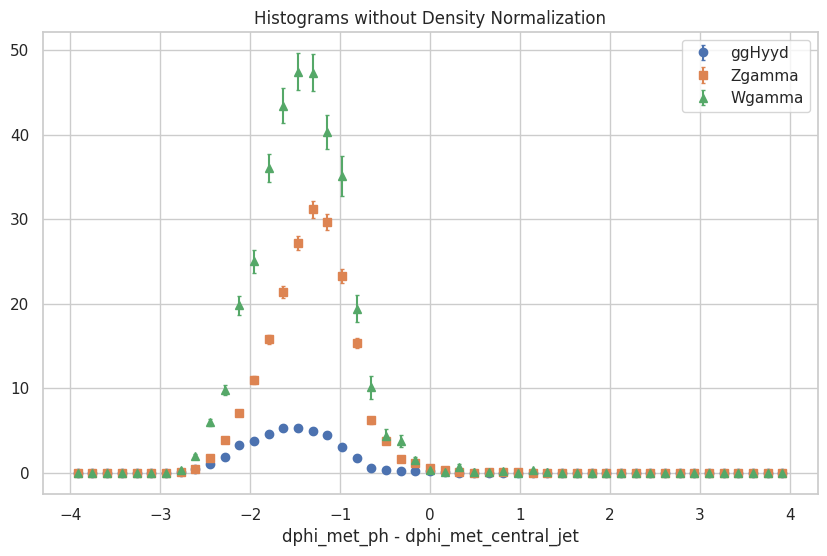

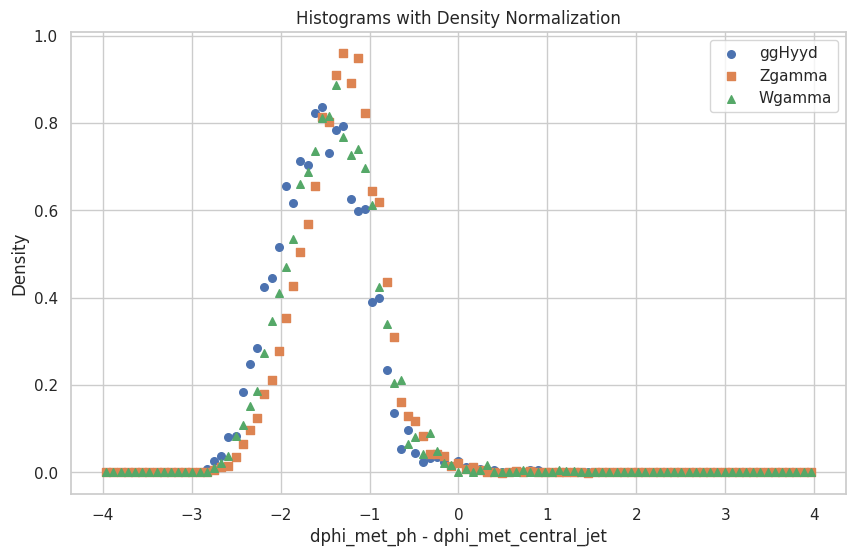

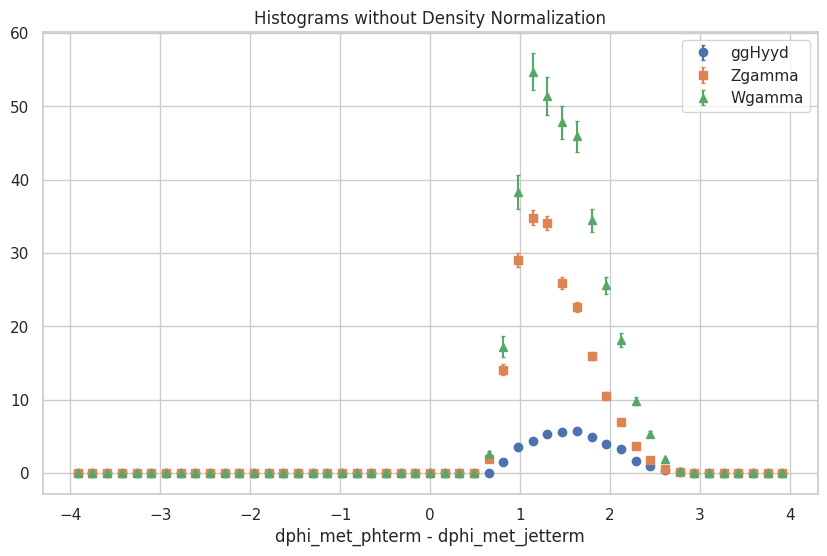

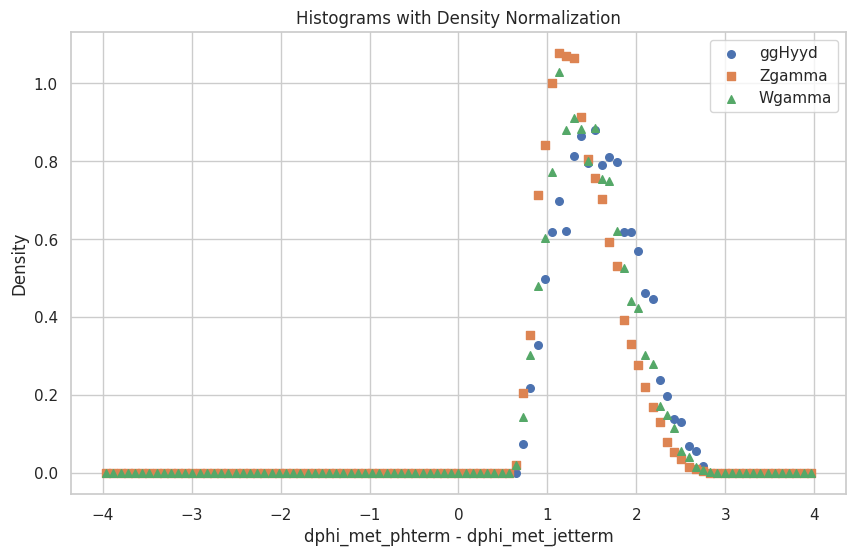

In [4]:
fb0, fb2, fb3 = tot[0], tot[2], tot[3]
def tmp(fb):
    tmp1 = np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))) - np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi'])))
    tmp1 = ak.fill_none(tmp1, -999)
    return tmp1
f0, f2, f3 = tmp(fb0), tmp(fb2), tmp(fb3)
w0, w2, w3 = getWeight(fb0, ntuple_name[0]), getWeight(fb2, ntuple_name[2]), getWeight(fb3, ntuple_name[3])

bins = np.linspace(-4, 4, 50)

# Function to calculate histogram with weights and uncertainty
def weighted_histogram(data, weights, bins):
    hist, bin_edges = np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # Calculate the uncertainty (sqrt of weighted sum of squares of the weights)
    uncertainty = np.sqrt(np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights**2)[0])
    
    return bin_centers, hist, uncertainty

# Plotting histograms for f0, f2, and f3
plt.figure(figsize=(10, 6))

# Histogram for f0 with uncertainty
bin_centers, hist_f0, unc_f0 = weighted_histogram(f0, w0, bins)
plt.errorbar(bin_centers, hist_f0, yerr=unc_f0, fmt='o', label='ggHyyd', capsize=1.5)

# Histogram for f2 with uncertainty
bin_centers, hist_f2, unc_f2 = weighted_histogram(f2, w2, bins)
plt.errorbar(bin_centers, hist_f2, yerr=unc_f2, fmt='s', label='Zgamma', capsize=1.5)

# Histogram for f3 with uncertainty
bin_centers, hist_f3, unc_f3 = weighted_histogram(f3, w3, bins)
plt.errorbar(bin_centers, hist_f3, yerr=unc_f3, fmt='^', label='Wgamma', capsize=1.5)

# Add labels and title
plt.xlabel('dphi_met_ph - dphi_met_central_jet')
plt.title('Histograms without Density Normalization')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Define the bins for the histogram
bins = np.linspace(-4, 4, 100)

# Function to calculate histogram with weights (without uncertainty)
def weighted_histogram(data, weights, bins):
    hist, bin_edges = np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

# Plotting histograms for f0, f2, and f3
plt.figure(figsize=(10, 6))

# Histogram for f0 with density normalization
bin_centers, hist_f0 = weighted_histogram(f0, w0, bins)
plt.scatter(bin_centers, hist_f0, label='ggHyyd', marker='o', s=30)  # 's' controls the size of the markers

# Histogram for f2 with density normalization
bin_centers, hist_f2 = weighted_histogram(f2, w2, bins)
plt.scatter(bin_centers, hist_f2, label='Zgamma', marker='s', s=30)

# Histogram for f3 with density normalization
bin_centers, hist_f3 = weighted_histogram(f3, w3, bins)
plt.scatter(bin_centers, hist_f3, label='Wgamma', marker='^', s=30)

# Add labels and title
plt.xlabel('dphi_met_ph - dphi_met_central_jet')
plt.ylabel('Density')
plt.title('Histograms with Density Normalization')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


fb0, fb2, fb3 = tot[0], tot[2], tot[3]
def tmp(fb):
    dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999)
    tmp1 = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) - dphi_met_jetterm_tmp
    tmp1 = ak.fill_none(tmp1, -999)
    return tmp1
f0, f2, f3 = tmp(fb0), tmp(fb2), tmp(fb3)
w0, w2, w3 = getWeight(fb0, ntuple_name[0]), getWeight(fb2, ntuple_name[2]), getWeight(fb3, ntuple_name[3])

bins = np.linspace(-4, 4, 50)

# Function to calculate histogram with weights and uncertainty
def weighted_histogram(data, weights, bins):
    hist, bin_edges = np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    
    # Calculate the uncertainty (sqrt of weighted sum of squares of the weights)
    uncertainty = np.sqrt(np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights**2)[0])
    
    return bin_centers, hist, uncertainty

# Plotting histograms for f0, f2, and f3
plt.figure(figsize=(10, 6))

# Histogram for f0 with uncertainty
bin_centers, hist_f0, unc_f0 = weighted_histogram(f0, w0, bins)
plt.errorbar(bin_centers, hist_f0, yerr=unc_f0, fmt='o', label='ggHyyd', capsize=1.5)

# Histogram for f2 with uncertainty
bin_centers, hist_f2, unc_f2 = weighted_histogram(f2, w2, bins)
plt.errorbar(bin_centers, hist_f2, yerr=unc_f2, fmt='s', label='Zgamma', capsize=1.5)

# Histogram for f3 with uncertainty
bin_centers, hist_f3, unc_f3 = weighted_histogram(f3, w3, bins)
plt.errorbar(bin_centers, hist_f3, yerr=unc_f3, fmt='^', label='Wgamma', capsize=1.5)

# Add labels and title
plt.xlabel('dphi_met_phterm - dphi_met_jetterm')
plt.title('Histograms without Density Normalization')

plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Define the bins for the histogram
bins = np.linspace(-4, 4, 100)

# Function to calculate histogram with weights (without uncertainty)
def weighted_histogram(data, weights, bins):
    hist, bin_edges = np.histogram(data, bins=bins, range=(min(data), max(data)), weights=weights, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

# Plotting histograms for f0, f2, and f3
plt.figure(figsize=(10, 6))

# Histogram for f0 with density normalization
bin_centers, hist_f0 = weighted_histogram(f0, w0, bins)
plt.scatter(bin_centers, hist_f0, label='ggHyyd', marker='o', s=30)  # 's' controls the size of the markers

# Histogram for f2 with density normalization
bin_centers, hist_f2 = weighted_histogram(f2, w2, bins)
plt.scatter(bin_centers, hist_f2, label='Zgamma', marker='s', s=30)

# Histogram for f3 with density normalization
bin_centers, hist_f3 = weighted_histogram(f3, w3, bins)
plt.scatter(bin_centers, hist_f3, label='Wgamma', marker='^', s=30)

# Add labels and title
plt.xlabel('dphi_met_phterm - dphi_met_jetterm')
plt.ylabel('Density')
plt.title('Histograms with Density Normalization')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [42]:
# Transposing the list using zip
transposed_acut = list(map(list, zip(*weighted_acut)))

# Printing the result
for i, row in enumerate(transposed_acut):
    print(f"Column {i+1}: {row}")


Column 1: [np.float32(525.4225), np.float32(3400.4272), np.float32(52896.68), np.float32(37458.25), np.float32(52856.816), np.float32(930477.94), np.float32(658565.06), np.float32(588102340.0)]
Column 2: [np.float32(438.0519), np.float32(869.52246), np.float32(17007.615), np.float32(16574.094), np.float32(21912.746), np.float32(59748.496), np.float32(123353.336), np.float32(257963.77)]
Column 3: [np.float32(348.48578), np.float32(678.58136), np.float32(15411.616), np.float32(13785.946), np.float32(17118.926), np.float32(14698.49), np.float32(18591.934), np.float32(19445.791)]
Column 4: [np.float32(305.75888), np.float32(133.51788), np.float32(2102.8906), np.float32(4059.9634), np.float32(7061.7886), np.float32(432.01257), np.float32(2972.4365), np.float32(1303.6265)]
Column 5: [np.float32(303.54465), np.float32(129.91539), np.float32(2071.5923), np.float32(3938.4373), np.float32(6918.244), np.float32(311.3839), np.float32(2751.7512), np.float32(942.101)]
Column 6: [np.float32(294.06525

In [46]:
len(transposed_acut)

10

In [45]:
# Table of before and after cut unweighted and weighted event
# metsig + dmet + dphi_ph_centraljet1 + dphi_met_phterm + dphi_jj cut + metsig2
pd.DataFrame({
    'process_file': ntuple_name,
    'before_cut': weighted_bcut,
    'basic_cut': transposed_acut[0],
    'BDTScore_cut': transposed_acut[1],
    'metsig_cut': transposed_acut[2],
    'dphi_met_phterm_cut': transposed_acut[3],
    'dmet_cut': transposed_acut[4],
    'dphi_met_jetterm_cut': transposed_acut[5],
    'ph_eta_cut': transposed_acut[6],
    'dphi_jj_cut': transposed_acut[7],
    'balance_cut': transposed_acut[8],
    'mt2_cut': transposed_acut[9],
    # 'selection ratio': np.array(weighted_acut)/np.array(weighted_bcut) * 100

    # 'weighted_before_cut': weighted_bcut,
    # 'after': unweighted_acut,
    # 'weighted_acut': weighted_acut,
})

,process_file,before_cut,basic_cut,BDTScore_cut,metsig_cut,dphi_met_phterm_cut,dmet_cut,dphi_met_jetterm_cut,ph_eta_cut,dphi_jj_cut,balance_cut,mt2_cut
0,ggHyyd,2.291852e+04,5.254225e+02,438.051910,348.485779,305.758881,303.544647,294.065247,258.330627,246.996658,243.877686,217.128433
1,Zjets,1.739104e+06,3.400427e+03,869.522461,678.581360,133.517883,129.915390,101.184326,79.275360,72.888069,71.749435,57.481285
2,Zgamma,3.101202e+05,5.289668e+04,17007.615234,15411.616211,2102.890625,2071.592285,1759.804199,1356.348145,1190.159058,1147.208862,1057.824951
3,Wgamma,5.676866e+05,3.745825e+04,16574.093750,13785.946289,4059.963379,3938.437256,3380.333496,2572.062744,2275.657715,2192.044434,1852.664429
4,Wjets,3.974293e+06,5.285682e+04,21912.746094,17118.925781,7061.788574,6918.244141,6713.872559,3652.888672,3401.447998,3264.326904,1559.919312
5,gammajet_direct,1.727299e+08,9.304779e+05,59748.496094,14698.490234,432.012573,311.383911,95.685349,61.370804,55.479950,55.466850,55.427418
6,gammajet_frag,1.487846e+08,6.585651e+05,123353.335938,18591.933594,2972.436523,2751.751221,2487.104736,1973.685425,928.744019,759.448120,474.709412
7,dijet,2.317966e+10,5.881023e+08,257963.765625,19445.791016,1303.626465,942.101013,486.607513,454.779236,16.434364,8.355230,8.355230


In [28]:
def sel(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]
        
        metsig_tmp = fb2['met_tst_sig'] # added cut 2 
        mask1 = metsig_tmp >= 7
        fb2 = fb2[mask1]
        # mask2 = metsig_tmp <= 13
        # fb2 = fb2[mask1 * mask2]

        dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) # added cut 3
        fb2 = fb2[dphi_met_phterm_tmp >= 1.35]

        dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et'] # added cut 4
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        fb2 = fb2[mask1 * mask2]

        # dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
        #                         np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
        #                         -999)
        # fb2 = fb2[dphi_met_jetterm_tmp <= 0.75]

        # ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta'])) # added cut 6
        # fb2 = fb2[ph_eta_tmp <= 1.75]


        # phi1_tmp = ak.firsts(fb2['jet_central_phi']) # added cut 7
        # phi2_tmp = ak.mask(fb2['jet_central_phi'], ak.num(fb2['jet_central_phi']) >= 2)[:, 1] 
        # dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        # dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
        # fb2 = fb2[dphi_jj_tmp <= 2.5]

        # jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        # expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        # balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
        # fb2 = fb2[balance_tmp >= 0.65]

        # mt_tmp = np.sqrt(2 * fb2['met_tst_et'] * ak.firsts(fb2['ph_pt']) * 
        #                     (1 - np.cos(fb2['met_tst_phi'] - ak.firsts(fb2['ph_phi'])))) / 1000
        # mask1 = mt_tmp >= 95
        # fb2 = fb2[mask1]

        
        tot2.append(fb2)
    return tot2

tot2 = sel(tot)

In [7]:
def findnone(arr):
    mask = ak.is_none(arr)

    n_none = ak.sum(mask)
    print("Number of None values:", n_none)

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 18
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})


In [4]:
tot2 = tot

In [38]:
def sel(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]
        
        metsig_tmp = fb2['met_tst_sig'] # added cut 2 
        mask1 = metsig_tmp >= 7
        fb2 = fb2[mask1]

        dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) # added cut 3
        fb2 = fb2[dphi_met_phterm_tmp >= 1.35]

        dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et'] # added cut 4
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        fb2 = fb2[mask1 * mask2]

        dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
                                np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
                                -999)
        fb2 = fb2[dphi_met_jetterm_tmp <= 0.70]

        ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta'])) # added cut 6
        fb2 = fb2[ph_eta_tmp <= 1.75]

        phi1_tmp = ak.firsts(fb2['jet_central_phi']) # added cut 7
        phi2_tmp = ak.mask(fb2['jet_central_phi'], ak.num(fb2['jet_central_phi']) >= 2)[:, 1] 
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
        fb2 = fb2[dphi_jj_tmp <= 2.5]

        jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
        fb2 = fb2[balance_tmp >= 0.65]

        # mt_tmp = np.sqrt(2 * fb2['met_tst_et'] * ak.firsts(fb2['ph_pt']) * 
        #                     (1 - np.cos(fb2['met_tst_phi'] - ak.firsts(fb2['ph_phi'])))) / 1000
        # mask1 = mt_tmp >= 95
        # fb2 = fb2[mask1]

        
        tot2.append(fb2)
    return tot2

tot2 = sel(tot)

cut_name = 'n-1'
var_config = getVarDict(tot2[0], 'ggHyyd', 'mt')
# cut_name = 'mt2'
# var_config = getVarDict(tot2[0], 'ggHyyd')

for var in var_config:
    # print(var)
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    # for j in range(len(ntuple_name)):
    for j in range(len(ntuple_name)-1): # leave dijet out
        process = ntuple_name[j]
        fb = tot2[j]  # TTree
        var_config = getVarDict(fb, process, var_name=var)

        x = var_config[var]['var'] # TBranch
        bins = var_config[var]['bins'] 

        if 'weight' in var_config[var]:  # If weight is there
            weights = var_config[var]['weight']
        else:
            weights = getWeight(fb, process)
        # findnone(x)
        # findnone(weights)

        # mask = x != -999 # **Apply Cut: Remove -999 values**
        # x = x[mask]
        # weights = weights[mask]

        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)
    # ax_top.set_title("vtx_sumPt distribution")

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram.
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance S/sqrt(B) (set to 0 if B==0)
    sig_per_bin = np.zeros_like(S_counts, dtype=float)
    sqrt_B = np.sqrt(B_counts)
    sig_per_bin = np.where(B_counts > 0, S_counts / sqrt_B, 0) # Use np.where to avoid division by zero
    sig_per_bin = np.nan_to_num(sig_per_bin) # Replace any possible NaNs with 0

    # Compute the bin centers for plotting.
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)
    if total_bkg > 0:
        total_sig = total_signal / np.sqrt(total_bkg)
    else:
        total_sig = 0

    ax_bot.step(bin_centers, sig_per_bin, where='mid', color='black', linewidth=2,
                label=f"Total S/√B = {total_sig:.5f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("S/√B")
    ax_bot.set_ylim(0, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    # Adjust layout and save the figure as a PNG.
    plt.tight_layout()
    # plt.savefig(f"../mc23d_metsig/{var}.png")
    # print(f"successfully saved to {var}.png")
    plt.savefig(f"../lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"successfully saved to lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    # Use the vtx_sumPt values as the classifier output.
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"../lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    print(f"successfully saved to lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to lumi135/mc23d_n-1cut/mt_nodijet.png
successfully saved to lumi135/mc23d_n-1cut/roc_curve_mt.png


## Back-up

In [ ]:

    var = {
        'vtx_sumPt': ak.flatten(fb['vtx_sumPt']),
        'n_ph': fb['n_ph'],
        'n_ph_baseline': fb['n_ph_baseline'],
        'n_el_baseline': fb['n_el_baseline'],
        'n_mu_baseline': fb['n_mu_baseline'],
        'n_tau_baseline': fb['n_tau_baseline'],
        'puWeight': fb['pu_weight'],
        'actualIntPerXing': fb['actualIntPerXing'],
        'mt': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
        'metsig': fb['met_tst_sig'],
        'metsigres': fb['met_tst_et'] / fb['met_tst_sig'],
        'met': fb['met_tst_et'],  # applying the '+50000' shift
        'met_noJVT': fb['met_tst_noJVT_et'],
        'met_cst': fb['met_cst_et'],
        'met_track': fb['met_track_et'],
        'dmet': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
        'ph_pt': ak.firsts(fb['ph_pt']),  # applying the '-150000' shift
        'ph_eta': np.abs(ak.firsts(fb['ph_eta'])),
        'ph_phi': ak.firsts(fb['ph_phi']),
        # 'jet_central_eta': ak.firsts(fb['jet_central_eta']),
        # 'jet_central_pt1': ak.firsts(fb['jet_central_pt']),
        # 'jet_central_pt2': fb['jet_central_pt'][ak.num(fb['jet_central_pt']) >= 2][:, 1],
        # 'jet_central_pt': fb['jet_central_pt'],
        'dphi_met_phterm': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
        'dphi_met_ph': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
        'dphi_met_jetterm': np.where(fb['met_jetterm_et'] != 0,
                                    np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                                    0),
        'dphi_phterm_jetterm': np.where(fb['met_jetterm_et'] > 0,
                                        np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                                        4),
        # 'dphi_ph_centraljet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_ph_jet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_central_jet1_jet2': np.arccos(np.cos(fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 0] - fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 1])),
        'metplusph': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
        # 'failJVT_jet_pt': fb['failJVT_jet_pt'],
        # 'failJVT_jet_pt1': ak.firsts(fb['failJVT_jet_pt']),
        'softerm': fb['met_softerm_tst_et'],
        'jetterm': fb['met_jetterm_et'],
        'jetterm_sumet': fb['met_jetterm_sumet'],
        'n_jet': fb['n_jet'],
        'n_jet_central': fb['n_jet_central'],
        'n_jet_fwd': fb['n_jet'] - fb['n_jet_central'],
        'vertex': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z'])),
        'goodPV': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5,
        # 'dphi_met_central_jet': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi']))),
        # 'counts': 0.5,
        # 'jet_central_timing1': ak.firsts(fb['jet_central_timing']),
        # 'jet_central_timing': fb['jet_central_timing'],
        # 'jet_central_emfrac': fb['jet_central_emfrac'],
        # 'jet_central_emfrac1': ak.firsts(fb['jet_central_emfrac']),
        'balance': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / np.sum(fb['jet_central_pt']), # need fixing 
        'balance_sumet': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / fb['met_jetterm_sumet'],
        'central_jets_fraction': np.where(fb['n_jet'] > 0, fb['n_jet_central'] / fb['n_jet'], -1),
        'trigger': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
        # 'dphi_jj': ak.Array([np.arccos(np.cos(phi[1] - phi[0])) if len(phi) > 1 else -1 for phi in fb['jet_central_phi']])
    }

    df = pd.DataFrame(var)

    data = pd.concat([data, df], ignore_index=True)


    # for key, value in var.items():
    #     try:
    #         print(f"{key:30s}: {len(value)}")
    #         print(f"{key:30s}: {value[:5]}")

    #     except Exception as e:
    #         print(f"{key:30s}: error getting length ({e})")

print(data.head())
